### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 24th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [60]:
import numpy as np 
import scipy
from scipy.stats import uniform, norm, rv_histogram
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import chainconsumer
import corner

# 1.1

In [3]:
# LSS loading data
data1 = np.load('../../../homeworks/hw_data/hw4_data_1.npy')

def het_mean_sigma_analytic(data):
    '''
    A function to analytically calculate the mean and uncert on mean for 
    a heteroscedastic dataset

    inputs:
    data (ndarray): N measurements x 2 array where [:, 1] are the uncertainties

    returns:
    mean (float): mean analytically calculated for heteroscedastic data
    sigmu (float): uncertainty on the mean analytically calc.
    '''
    numerator = np.sum(data[:, 0] / data[:, 1]**2) # LSS sum of measurement over
    # the square of the respective uncertainties
    denom = np.sum(data[:, 1]**-2) # LSS sum of the inverse square of the uncert.

    mean = numerator / denom

    sigmu = denom**-0.5 # LSS uncert on mean is denominator to the -0.5
    return mean, sigmu

data1mu_an, data1sig_an = het_mean_sigma_analytic(data1)


In [4]:
data1mu_an

4.942118214425304

In [5]:
print(data1mu_an+data1sig_an)
print(data1mu_an-data1sig_an)


5.372361560477355
4.511874868373253


# 1.2

In [6]:
def neglnlik(mu_model, data, uncert, modelname='gaussian', scaleparam=np.nan):
    '''
    A function to return the negative log likelihood for data when modeled by a 
    gaussian with mu=mu_model

    inputs:
    mu_model (float): mean for the gaussian model
    data (ndarray): the data to be fit to 
    uncert (ndarray): the uncert for each data point
    outputs:
    neglnlik (float): negative log likelihood for some mu_model 
    '''
    if modelname=='gaussian':
        # LSS calculating likelihood
        neglnlik = np.sum(np.log(1/(uncert*np.sqrt(2*np.pi))) - ((data - mu_model)**2 / (2*uncert**2)))
    
    elif modelname=='laplace': # LSS encoding laplace model
        if np.isnan(scaleparam):
            print('MUST ASSIGN SCALE PARAMETER IF USING LAPLACE MODEL')
            return
        neglnlik = np.sum(np.log(1/(2*scaleparam))+-(np.abs(data-mu_model)/scaleparam))

    return -neglnlik

In [7]:
# LSS testing neglnlik function
neglnlik(4, data1[:, 0], data1[:, 1])

# LSS finding max ln lik (min negative)
nlnlik_mu1guess = lambda muguess: neglnlik(muguess, data=data1[:, 0], 
                                          uncert=data1[:, 1])
muguess0 = 3
mu1_MLE = optimize.fmin(nlnlik_mu1guess, muguess0)

Optimization terminated successfully.
         Current function value: 16.048013
         Iterations: 17
         Function evaluations: 34


In [8]:
print(f'MLE estimate: {mu1_MLE[0]}')
print(f'analytic est: {data1mu_an}')

MLE estimate: 4.942089843750004
analytic est: 4.942118214425304


## 1.3

In [9]:
# LSS defining prior

def mu1prior1(x):
    return uniform(loc=3, scale=4).pdf(x)

# LSS making mu grid
mugrid = np.linspace(3, 7, 1000)

# LSS calculating posterior
posterior_prior1 = np.zeros((1000))
for i in range(1000):
    posterior_prior1[i] =np.exp(-neglnlik(mugrid[i], data=data1[:,0], uncert=data1[:, 1]))*mu1prior1(mugrid[i])

# LSS normalizing
posterior_prior1 = posterior_prior1 / (np.sum(posterior_prior1)*(mugrid[1]-mugrid[0]))

Text(0.5, 1.0, 'posterior on voltage mean')

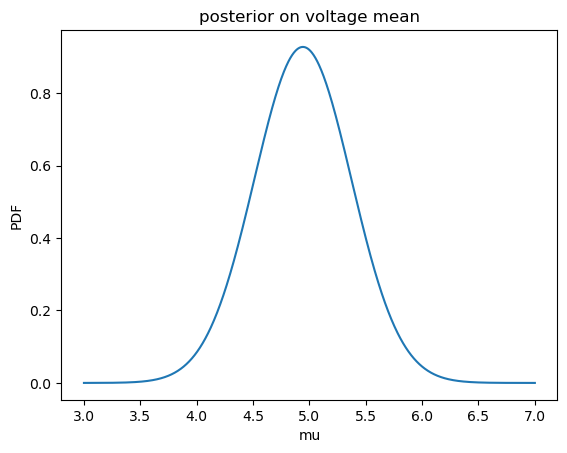

In [10]:
plt.plot(mugrid, posterior_prior1)
plt.xlabel('mu')
plt.ylabel('PDF')
plt.title('posterior on voltage mean')

# 1.4

Text(0.5, 1.0, 'CDF')

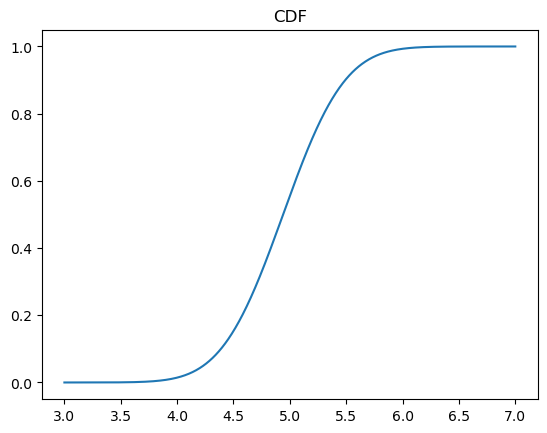

In [11]:
# LSS making CDF from normalized posteriod
cdf_prior1 = np.cumsum(posterior_prior1)
cdf_prior1 = cdf_prior1 * (mugrid[1]-mugrid[0])
plt.plot(mugrid, cdf_prior1)
plt.title('CDF')

In [12]:
# finding MAP mu
mu1_MAP = mugrid[np.where(posterior_prior1==posterior_prior1.max())[0]][0]

# calculating heteroscedastic gaussian sigma_mu
mu_sigma_calc = (np.sum(1/(data1[:,1]**2)))**(-1/2)

In [13]:
print(mu1_MAP+mu_sigma_calc)
print(mu1_MAP-mu_sigma_calc)


5.372185287993993
4.511698595889891


In [14]:
mu_sigma_calc

0.43024334605205083

In [15]:
# LSS finding 68.3% credible interval by finding 1st index in CDF greater than
# LSS and finding last index in CDF less than limit
low683 = mugrid[np.where(cdf_prior1 >= .1585)[0][0]]
hi683  = mugrid[np.where(cdf_prior1 <= .8415)[0][-1]]
print(low683)
print(hi683)

4.513513513513514
5.37037037037037


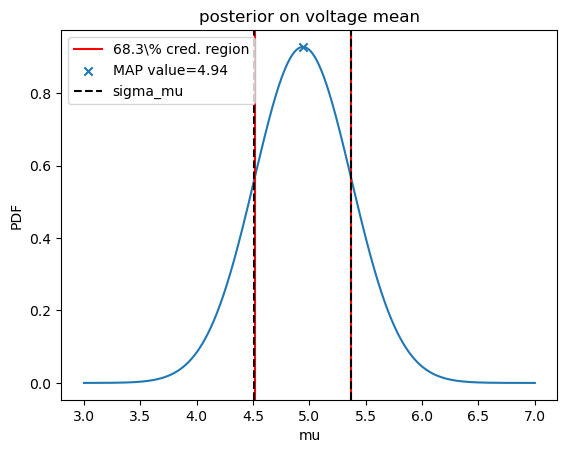

In [16]:
plt.plot(mugrid, posterior_prior1)
plt.axvline(low683, color='r', label='68.3\% cred. region')
plt.axvline(hi683, color='r')
plt.scatter(mu1_MAP, posterior_prior1[np.where(posterior_prior1==posterior_prior1.max())[0]],
             marker='x', label=f'MAP value={mu1_MAP:.2f}')
plt.axvline(mu1_MAP+mu_sigma_calc, linestyle='dashed', color='k', label='sigma_mu')
plt.axvline(mu1_MAP-mu_sigma_calc, linestyle='dashed', color='k')
plt.ylabel('PDF')
plt.title('posterior on voltage mean')
plt.xlabel('mu')
plt.legend(loc=2)

# 1.5

In [17]:
def calcpost_plot(mugrid, muprior, data, uncerts, plot=True):
    '''
    calculates normalized posterior from heteroscedastic data, modeled as gaussian

    '''
    # LSS calculating posterior
    posterior = np.zeros((mugrid.shape[0]))
    for i in range(mugrid.shape[0]):
        posterior[i] = np.exp(-neglnlik(mugrid[i], data=data, uncert=uncerts))*muprior(mugrid[i])

    # LSS normalizing
    posterior = posterior / (np.sum(posterior)*(mugrid[1]-mugrid[0]))

    # LSS create CDF for credible interval calculations
    cdf = np.cumsum(posterior)
    cdf = cdf * (mugrid[1]-mugrid[0]) # LSS normalize

    # LSS finding MAP mu
    mu1_MAP = mugrid[np.where(posterior==posterior.max())[0]][0]
    print(f'mu MAP = {mu1_MAP}')

    # LSS calculating heteroscedastic gaussian sigma_mu
    mu_sigma_calc = (np.sum(1/(uncerts**2)))**(-1/2)
    print(f'sigma_mu = {mu_sigma_calc}')

    # LSS finding 68.3% credible interval by finding 1st index in CDF greater than
    # LSS and finding last index in CDF less than limit
    low683 = mugrid[np.where(cdf >= .1585)[0][0]]
    hi683  = mugrid[np.where(cdf <= .8415)[0][-1]]
    print(f'+/- 1 sigma = {hi683}/{low683}')

    ##### Plotting ######
    if plot:
        ax1 = plt.subplot(211)
        ax1.plot(mugrid, posterior)
        ax1.axvline(low683, color='r', label='68.3\% cred. region')
        ax1.axvline(hi683, color='r')
        ax1.scatter(mu1_MAP, posterior[np.where(posterior==posterior.max())[0]],
                    marker='x', label=f'MAP value={mu1_MAP:.2f}')
        ax1.axvline(mu1_MAP+mu_sigma_calc, linestyle='dashed', color='k', label='sigma_mu')
        ax1.axvline(mu1_MAP-mu_sigma_calc, linestyle='dashed', color='k')
        ax1.set_ylabel('PDF')
        ax1.set_title('posterior on voltage mean')
        ax1.legend(loc=2)
        ax2 = plt.subplot(212, sharex=ax1)
        ax2.plot(mugrid, cdf, label='CDF', linestyle='dashed')
        ax2.set_xlabel('mu')
        ax2.set_ylabel('percentile')
        ax2.legend()
        plt.show()
    
    return posterior, cdf, mu1_MAP, mu_sigma_calc
        

mu MAP = 4.944944944944945
sigma_mu = 0.43024334605205083
+/- 1 sigma = 5.365365365365365/4.514514514514515


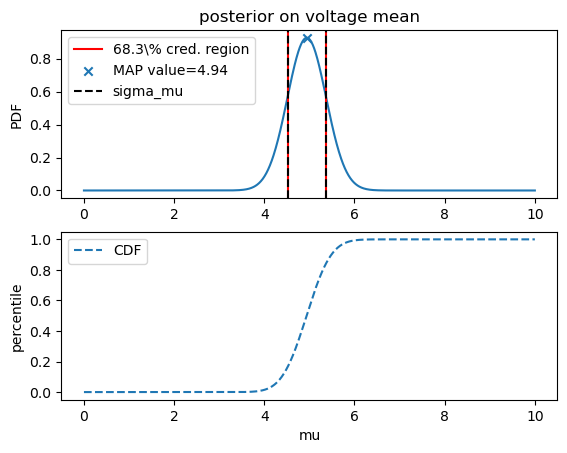

In [18]:
def mu1prior1(x):
    return uniform(loc=3, scale=4).pdf(x)

# LSS making mu grid
mugrid1 = np.linspace(0, 10, 1000)

post_test, cdf_test, mumap_test, musigma_test = calcpost_plot(mugrid1, mu1prior1, data1[:, 0], data1[:, 1])

mu MAP = 4.944944944944945
sigma_mu = 0.43024334605205083
+/- 1 sigma = 5.225225225225225/4.734734734734735


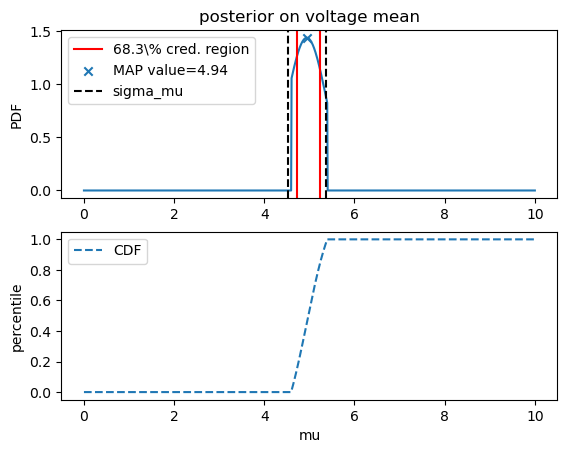

In [19]:
def mu1prior2(x):
    return uniform(loc=4.6, scale=.8).pdf(x)


# def mu1prior2(x):
#     return uniform(loc=4.6, scale=1).pdf(x)

# # LSS making mu grid
# mugrid2 = np.linspace(4.6, 5.6, 1000)

post_2, cdf_2, mumap_2, musigma_2 = calcpost_plot(mugrid1, mu1prior2, data1[:, 0], data1[:, 1])

# 1.6

In [20]:
# LSS getting gaussian prior
def prior_gauss(x): return norm(6, 0.3).pdf(x)

* NOTE: return red values (equal tailed 68%) and dist from median as in median +__/-___

mu MAP = 5.655655655655655
sigma_mu = 0.43024334605205083
+/- 1 sigma = 5.885885885885886/5.405405405405405


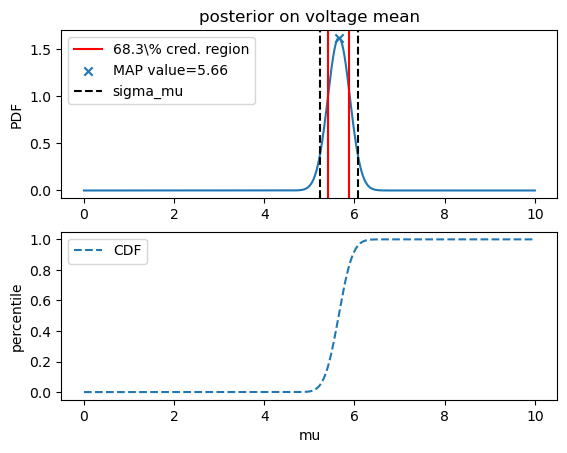

In [21]:
post_3, cdf_3, mumap_3, musigma_3 = calcpost_plot(mugrid1, prior_gauss, data1[:, 0], data1[:, 1])

# 1.7

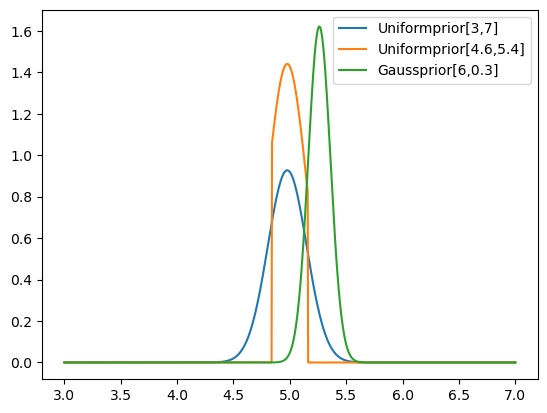

In [22]:
plt.plot(mugrid, post_test, label='Uniformprior[3,7]')
plt.plot(mugrid, post_2, label='Uniformprior[4.6,5.4]')
plt.plot(mugrid, post_3, label='Gaussprior[6,0.3]')
plt.legend()

# 1.8

In [23]:
# LSS calculating evidence for different 
evidence_df = np.exp(-neglnlik(data1mu_an, data1[:, 0], data1[:, 1]))
evidence_ga = np.sum(post_3) * (mugrid[1]-mugrid[0])
print(f'Bayes Factor gaussian/df = {evidence_ga/evidence_df}')


Bayes Factor gaussian/df = 3729265.97495162


## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [24]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

# 2.1

In [25]:
data2 = np.load('../../../homeworks/hw_data/hw4_data_2.npy')


In [26]:
x, y, sigma_y = data2

# 2.2

In [27]:
def slopeuniformprior(x): return uniform(loc=0.5, scale=1).pdf(x)

# LSS adding intercept at start of array
slopegrid = np.linspace(0.5, 1.5, 100)
int_slope_arr = np.zeros((2, 100))
int_slope_arr[1, :] = slopegrid
int_slope_arr[0, :] = -0.23
post_slope = np.zeros((100))

for idx in range(100):
    post_slope[idx] = np.exp(logL(int_slope_arr[:, idx], data2)) * slopeuniformprior(slopegrid[idx])

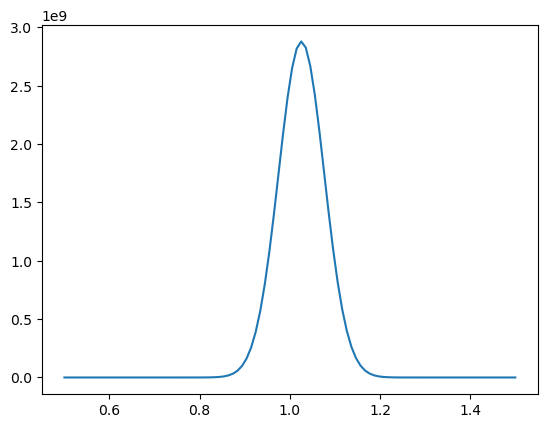

In [28]:
plt.plot(slopegrid, post_slope)

# 2.3

In [29]:
evidence_slope = np.sum(post_slope)*(slopegrid[1]-slopegrid[0])
print(f'{evidence_slope=}')

evidence_slope=365684733.1606578


# 2.4

In [101]:
def quaduniformprior(x): return uniform(loc=-1, scale=1.25).pdf(x)

quadgrid = np.linspace(-1, 0.25, 100)

dslope = slopegrid[1] - slopegrid[0]
dquad = quadgrid[1] - quadgrid[0]

intercept = -0.23
post_slope_quad = np.zeros((100, 100))

In [107]:
for sidx in range(100):
    for qidx in range(100):
        post_slope_quad[sidx,qidx] = (np.exp(logL([intercept, slopegrid[sidx], quadgrid[qidx]], data2)) 
                            * slopeuniformprior(slopegrid[sidx]) 
                            * quaduniformprior(quadgrid[qidx]))

In [141]:
# LSS making normalized conditional posteriors
postsq_quad = (np.sum(post_slope_quad, axis=1)*dslope) / (np.sum(post_slope_quad)*dslope*dquad)
postsq_slope = (np.sum(post_slope_quad, axis=0)*dquad) / (np.sum(post_slope_quad)*dslope*dquad)

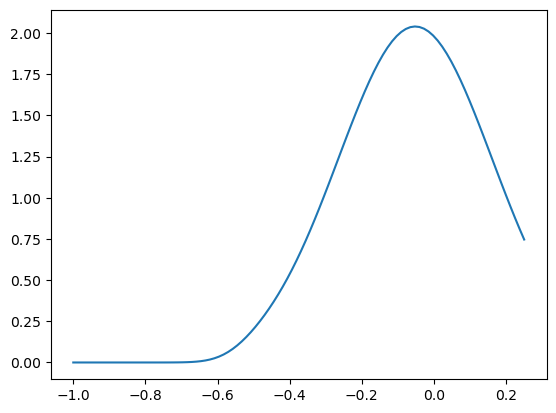

In [142]:
plt.plot(quadgrid, postsq_quad)

In [146]:
np.sum(postsq_quad)*dquad

1.0000000000000002

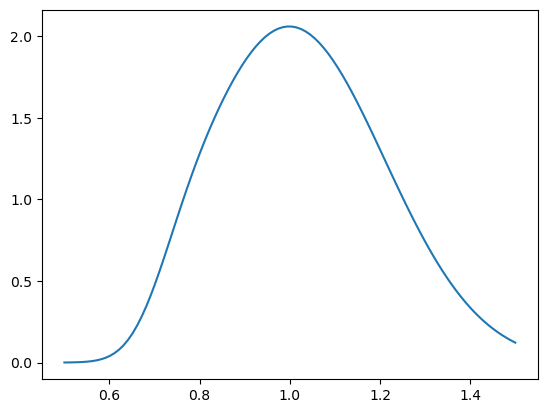

In [144]:
plt.plot(slopegrid, postsq_slope)

In [145]:
np.sum(postsq_slope*dslope)

1.0

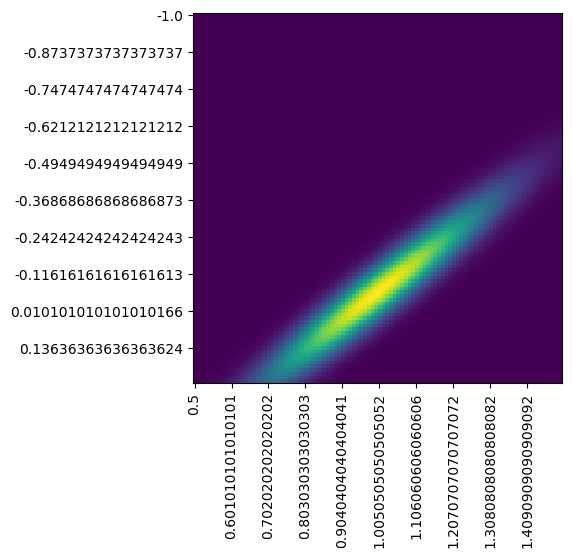

In [100]:
plt.imshow(post_slope_quad)
plt.xticks(ticks=np.arange(0, 100, 10), labels=slopegrid[::10], rotation=90);
plt.yticks(ticks=np.arange(0, 100, 10), labels=quadgrid[::10]);
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# 2.5

In [121]:
evidencequad = np.sum(post_slope_quad)*dslope*dquad

# 2.6

In [122]:
print(f'BF for linear/quad model: {evidence_slope/evidencequad}')

BF for linear/quad model: 0.7416622526050152


In [147]:
def BIC(maxlnlik, numparams, ndatapts):
    '''
    calculates the BIC for a model. note that max LOG likelihood is passed in
    '''
    bic = numparams*np.log(ndatapts) - 2 * maxlnlik
    return bic

In [148]:
# LSS technically I would have to divide by the prior at each point, but since
# LSS both priors are uniform, I can just divide the whole posterior by their 
# LSS product to get the Likelihood
like_sq = post_slope_quad / (slopeuniformprior(slopegrid[0]) * quaduniformprior(quadgrid[0]))

In [149]:
like_s = post_slope / slopeuniformprior(slopegrid[0])

In [154]:
bic_s = BIC(np.log(like_s.max()), 1, data2.shape[1])
bic_sq = BIC(np.log(like_sq.max()), 2, data2.shape[1])

In [155]:
print(f'BIC for slope model =      {bic_s}')
print(f'BIC for slope+quad model = {bic_sq}')

BIC for slope model =      -40.56497783764137
BIC for slope+quad model = -39.60826138257528
